# Introduction to Deep Learning: Homework 1

**Nathan Inkawhich**

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Nathan Inkawhich

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Training image data: (55000, 784)
Validation image data: (5000, 784)
Testing image data: (10000, 784)
28 x 28 = 784

Test Labels: (10000, 10)
Label distribution:[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]

Train image 1 is labelled one-hot

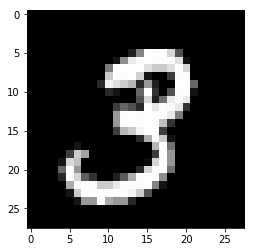

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import trange
from tensorflow.examples.tutorials.mnist import input_data

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Dataset statistics
print('Training image data: {0}'.format(mnist.train.images.shape))
print('Validation image data: {0}'.format(mnist.validation.images.shape))
print('Testing image data: {0}'.format(mnist.test.images.shape))
print('28 x 28 = {0}'.format(28*28))

print('\nTest Labels: {0}'.format(mnist.test.labels.shape))
labels = np.arange(10)
num_labels = np.sum(mnist.test.labels, axis=0, dtype=np.int)
print('Label distribution:{0}'.format(list(zip(labels, num_labels))))

# Example image
print('\nTrain image 1 is labelled one-hot as {0}'.format(mnist.train.labels[1,:]))
image = np.reshape(mnist.train.images[1,:],[28,28])
plt.imshow(image, cmap='gray')

## Problem 2: Algorithmic Implementation of a Multi-Class Logistic Regression without Tensorflow (30 Points)

### Helper Functions for Training

In [2]:
# Softmax function. Works on vector inputs and returns a vector.
def softmax(logits):
    ex = np.exp(logits)
    return ex/np.sum(ex)

# Cross Entropy function. Calculates xent between predictions (y_hat) and ground truth (y)
def xent(y_hat, y):
    return -1*np.sum(y*np.log(y_hat))

# Calculates the derivaive of the softmax vector w.r.t the input values
#    note: after simplification, the calculations only require what is 
#          already in the softmax vector
def calc_softmax_grad(smax):
    mat = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            if i == j:
                mat[i,j] = smax[i]*(1-smax[j])
            else:
                mat[i,j] = -smax[i]*smax[j]
    return mat

# Measure test or validation accuracy given the current parameters of the model, W & b
def measure_accuracy(W,b, val=True):
    
    if val:
        iters = mnist.validation.images.shape[0]
    else: 
        iters = mnist.test.images.shape[0]
        
    num_correct = 0
    for _ in range(iters):
        if val:
            x,y = mnist.validation.next_batch(1)
        else:
            x,y = mnist.test.next_batch(1)
        x = x.T
        y = y.T
        a = np.matmul(W,x) + b
        s = softmax(a)
        pred = np.argmax(s)
        gt = np.argmax(y)
        if pred == gt:
            num_correct += 1
            
    return num_correct/float(iters)

### Main Training Loop

In [3]:
# Train the multi-class logistic regression model

# Learning rate for parameter updates
lr = .05
# Number of training iterations
train_iters = 30000
# Zero initialized weight matrix
W = np.zeros((10,784))
# Zero initialized bias vector
b = np.zeros((10,1))

# Lists for keeping history of learning process
val_accuracy_history = []
train_loss_history = []
its_history = []
best_val_acc = 0

# Train Loop
for it in trange(train_iters):

    # Get data sample for training
    x, y = mnist.train.next_batch(1)
    x = x.T
    y = y.T

    # Forward Pass

    a = np.matmul(W,x) + b
    s = softmax(a)

    # Calculate Loss
    
    loss = xent(s,y)

    # Backward Pass

    dloss_ds = y*(-1/s)
    ds_da = calc_softmax_grad(s)
    delta = np.matmul(dloss_ds.T, ds_da).T
    # dloss_dW = dloss_ds * ds_da * da_dW
    dloss_dW = np.matmul(delta, x.T)
    # dloss_db = dloss_ds * ds_da * da_db
    dloss_db = delta

    # Update Params to minimize loss
    
    W = W - lr*dloss_dW
    b = b - lr*dloss_db
    
    # Save status once in a while
    if it % 100 == 0:
        val_accuracy_history.append(measure_accuracy(W,b,val=True))
        train_loss_history.append(loss)
        its_history.append(it)
        
print("\n*****************************")
print("Best Val Accuracy = ", max(val_accuracy_history))
print("Final Val Accuracy = ", measure_accuracy(W,b,val=True))
print("Final Test Accuracy = ", measure_accuracy(W,b,val=False))

100%|██████████| 30000/30000 [00:38<00:00, 780.05it/s]



*****************************
Best Val Accuracy =  0.9112
Final Val Accuracy =  0.896
Final Test Accuracy =  0.8996


### Plot Training Results

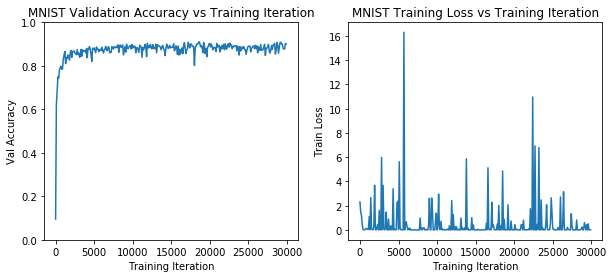

In [4]:
# Plot training progress
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("MNIST Validation Accuracy vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Val Accuracy")
plt.ylim((0,1))
plt.plot(its_history,val_accuracy_history)
plt.subplot(1,2,2)
plt.title("MNIST Training Loss vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Train Loss")
plt.plot(its_history,train_loss_history)
plt.show()

## Problem 3: Algorithmic Implementation of a Multi-Class Logistic Regression with Tensorflow (30 Points)

### (a)	Set up a logistic regression network, and learn it on MNIST using stochastic gradient descent.

This will be an exact replica of the model from Problem 2, except we will implement the model with Tensorflow. We will use the same $batch\_size=1$, $train\_iters=10000$, and $lr=0.05$ for a fair comparison.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



100%|██████████| 30000/30000 [00:20<00:00, 1436.52it/s]



*****************************
Best Val Accuracy:  0.9144
Final Val accuracy: 0.9057999849319458
Final Test accuracy: 0.8970000147819519


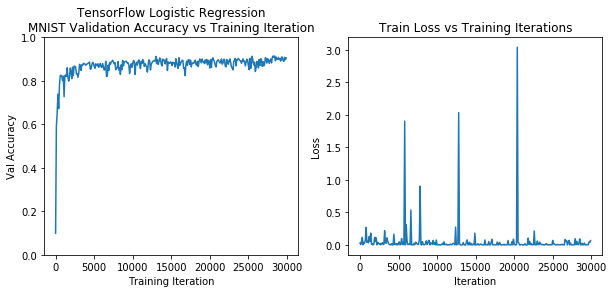

In [5]:
tf.reset_default_graph()

# Import data again so we train on the same data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Learning rate for parameter updates
lr = .05
# Number of training iterations
train_iters = 30000

# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)

# Create a Session object, initialize all variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# History keepers
val_accuracy_history = []
train_loss_history = []
its_history = []

# Train Loop
for it in trange(train_iters):
    batch_xs, batch_ys = mnist.train.next_batch(1)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    
    # Save status once in a while
    if it % 100 == 0:
        gt_preds = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        val_acc = tf.reduce_mean(tf.cast(gt_preds, tf.float32))
        val_accuracy_history.append(sess.run(val_acc, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels}))
        its_history.append(it)
        train_loss_history.append(sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys}))
        
# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("\n*****************************")
print("Best Val Accuracy: ",max(val_accuracy_history))
print('Final Val accuracy: {}'.format(sess.run(accuracy, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})))
print('Final Test accuracy: {}'.format(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("TensorFlow Logistic Regression\nMNIST Validation Accuracy vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Val Accuracy")
plt.ylim((0,1))
plt.plot(its_history,val_accuracy_history)
plt.subplot(1,2,2)
plt.title("Train Loss vs Training Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(its_history,train_loss_history)
plt.show()

sess.close()

### (b)	Set up an MLP with a single hidden layer (you can choose the number of hidden nodes) and learn it on MNIST using stochastic gradient descent.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


100%|██████████| 100000/100000 [02:08<00:00, 775.56it/s]



**********************************
Number of hidden layer nodes:  10
Best Val Accuracy:  0.9106
Final Val accuracy: 0.9064000248908997
Final Test accuracy: 0.9053000211715698


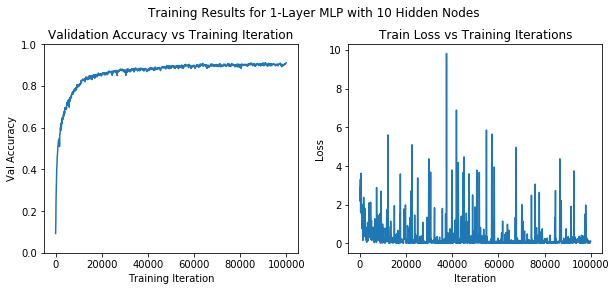

100%|██████████| 100000/100000 [04:56<00:00, 336.87it/s]



**********************************
Number of hidden layer nodes:  20
Best Val Accuracy:  0.9206
Final Val accuracy: 0.9151999950408936
Final Test accuracy: 0.9122999906539917


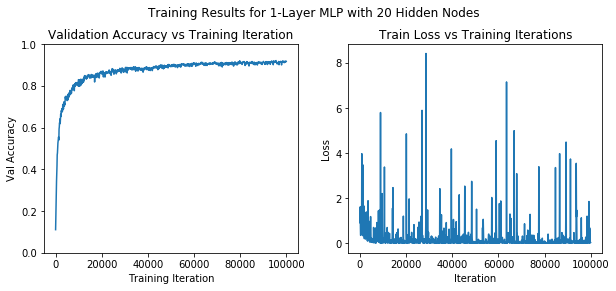

100%|██████████| 100000/100000 [07:58<00:00, 208.89it/s]



**********************************
Number of hidden layer nodes:  50
Best Val Accuracy:  0.9428
Final Val accuracy: 0.9351999759674072
Final Test accuracy: 0.9301999807357788


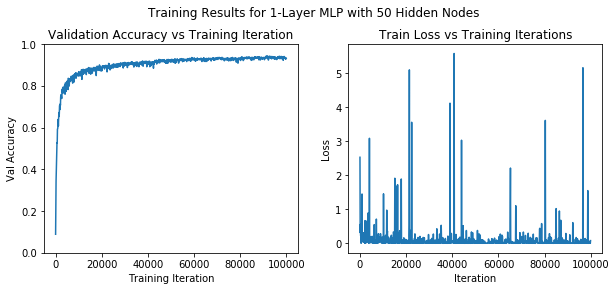

100%|██████████| 100000/100000 [11:11<00:00, 148.96it/s]



**********************************
Number of hidden layer nodes:  100
Best Val Accuracy:  0.942
Final Val accuracy: 0.923799991607666
Final Test accuracy: 0.9248999953269958


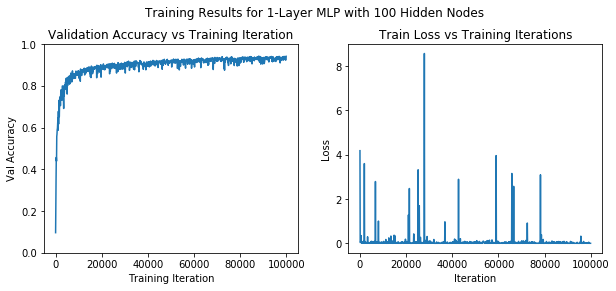

In [6]:
tf.reset_default_graph()

# Import data again so we train on the same data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Learning rate for parameter updates
lr = .05
# Number of training iterations
train_iters = 100000

for h1_nodes in [10,20,50,100]:
    
    # Input placeholders 
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])

    # Parameters to learn
    W_1 = tf.Variable(tf.random_normal([784, h1_nodes]))
    b_1 = tf.Variable(tf.random_normal([h1_nodes]))
    W_2 = tf.Variable(tf.random_normal([h1_nodes, 10]))
    b_2 = tf.Variable(tf.random_normal([10]))

    # Build Forward Pass for 1-hidden layer MLP
    h1 = tf.matmul(x, W_1) + b_1
    a1 = tf.nn.sigmoid(h1)
    h2 = tf.matmul(a1, W_2) + b_2

    # Define loss and optimizer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=h2))
    train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)
    
    # Create a Session object, initialize all variables
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # History keepers
    val_accuracy_history = []
    train_loss_history = []
    its_history = []

    # Train Loop
    for it in trange(train_iters):
        batch_xs, batch_ys = mnist.train.next_batch(1)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

        # Save status once in a while
        if it % 100 == 0:
            gt_preds = tf.equal(tf.argmax(h2, 1), tf.argmax(y_, 1))
            val_acc = tf.reduce_mean(tf.cast(gt_preds, tf.float32))
            val_accuracy_history.append(sess.run(val_acc, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels}))
            its_history.append(it)
            train_loss_history.append(sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys}))


    # Test trained model
    correct_prediction = tf.equal(tf.argmax(h2, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("\n**********************************")
    print("Number of hidden layer nodes: ", h1_nodes)
    print("Best Val Accuracy: ",max(val_accuracy_history))
    print('Final Val accuracy: {}'.format(sess.run(accuracy, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})))
    print('Final Test accuracy: {}'.format(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})))

    # Plot Results
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Validation Accuracy vs Training Iteration")
    plt.xlabel("Training Iteration")
    plt.ylabel("Val Accuracy")
    plt.ylim((0,1))
    plt.plot(its_history,val_accuracy_history)
    plt.subplot(1,2,2)
    plt.title("Train Loss vs Training Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(its_history,train_loss_history)
    plt.suptitle("Training Results for 1-Layer MLP with {} Hidden Nodes".format(h1_nodes))
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    sess.close()

### (c)	Set up an MLP with two hidden layers (i.e. lecture 2, slide 55)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


100%|██████████| 100000/100000 [02:15<00:00, 735.38it/s]



**********************************
[ first layer nodes, second layer nodes ] = [ 10, 10 ]
Best Val Accuracy:  0.8886
Final Val accuracy: 0.8781999945640564
Final Test accuracy: 0.8708000183105469


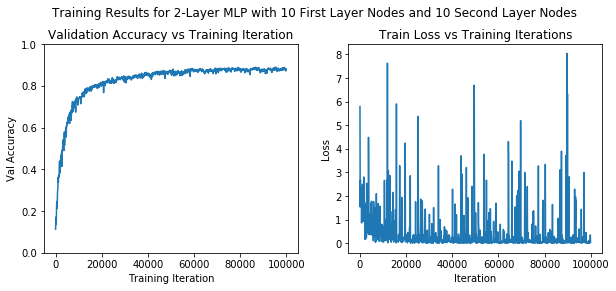

100%|██████████| 100000/100000 [05:06<00:00, 325.88it/s]



**********************************
[ first layer nodes, second layer nodes ] = [ 20, 20 ]
Best Val Accuracy:  0.9212
Final Val accuracy: 0.9154000282287598
Final Test accuracy: 0.9111999869346619


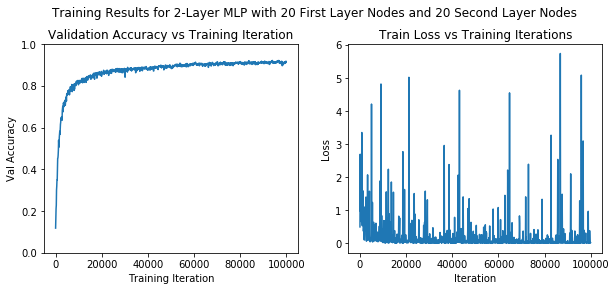

100%|██████████| 100000/100000 [08:24<00:00, 198.08it/s]



**********************************
[ first layer nodes, second layer nodes ] = [ 50, 50 ]
Best Val Accuracy:  0.9374
Final Val accuracy: 0.9300000071525574
Final Test accuracy: 0.929099977016449


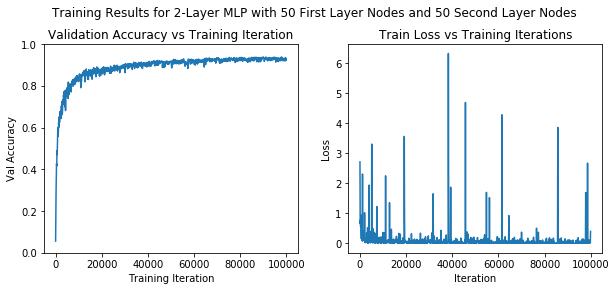

100%|██████████| 100000/100000 [11:50<00:00, 140.69it/s]



**********************************
[ first layer nodes, second layer nodes ] = [ 100, 100 ]
Best Val Accuracy:  0.944
Final Val accuracy: 0.9362000226974487
Final Test accuracy: 0.9369999766349792


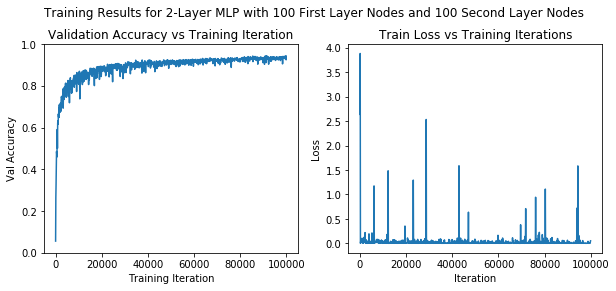

In [7]:
tf.reset_default_graph()

# Import data again so we train on the same data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Learning rate for parameter updates
lr = .05
# Number of training iterations
train_iters = 100000

for h1_nodes,h2_nodes in [[10,10],[20,20],[50,50],[100,100]]:
    
    # Input placeholders 
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])

    # Parameters to learn
    W_1 = tf.Variable(tf.random_normal([784, h1_nodes]))
    b_1 = tf.Variable(tf.random_normal([h1_nodes]))
    W_2 = tf.Variable(tf.random_normal([h1_nodes, h2_nodes]))
    b_2 = tf.Variable(tf.random_normal([h2_nodes]))
    W_3 = tf.Variable(tf.random_normal([h2_nodes, 10]))
    b_3 = tf.Variable(tf.random_normal([10]))

    # Build Forward Pass for 2-hidden layer MLP
    h1 = tf.matmul(x, W_1) + b_1
    a1 = tf.nn.sigmoid(h1)
    h2 = tf.matmul(a1, W_2) + b_2
    a2 = tf.nn.sigmoid(h2)
    h3 = tf.matmul(a2, W_3) + b_3

    # Define loss and optimizer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=h3))
    train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)

    # Create a Session object, initialize all variables
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # History keepers
    val_accuracy_history = []
    train_loss_history = []
    its_history = []

    # Train Loop
    for it in trange(train_iters):
        batch_xs, batch_ys = mnist.train.next_batch(1)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

        # Save status once in a while
        if it % 100 == 0:
            gt_preds = tf.equal(tf.argmax(h3, 1), tf.argmax(y_, 1))
            val_acc = tf.reduce_mean(tf.cast(gt_preds, tf.float32))
            val_accuracy_history.append(sess.run(val_acc, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels}))
            its_history.append(it)
            train_loss_history.append(sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys}))

    # Test trained model
    correct_prediction = tf.equal(tf.argmax(h3, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("\n**********************************")
    print("[ first layer nodes, second layer nodes ] = [ {}, {} ]".format(h1_nodes,h2_nodes))
    print("Best Val Accuracy: ",max(val_accuracy_history))
    print('Final Val accuracy: {}'.format(sess.run(accuracy, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})))
    print('Final Test accuracy: {}'.format(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})))

    # Plot Results
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Validation Accuracy vs Training Iteration")
    plt.xlabel("Training Iteration")
    plt.ylabel("Val Accuracy")
    plt.ylim((0,1))
    plt.plot(its_history,val_accuracy_history)
    plt.subplot(1,2,2)
    plt.title("Train Loss vs Training Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(its_history,train_loss_history)
    plt.suptitle("Training Results for 2-Layer MLP with {} First Layer Nodes and {} Second Layer Nodes".format(h1_nodes,h2_nodes))
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    sess.close()

## Problem 4: Performance Comparison (20 points)

The evidence for these questions all come from the results and plots printed when training each model.

### (a)	Did your implementations and Tensorflow’s implementations from problems 2 and 3 perform the same?

Yes, both implementations performed the same. The best observed validation accuracies for my implementation and the TF implementation are 91.12% and 91.44%, respectively. After training had completed, both implementations achieved about 90% accuracy on the test set with the final models. 

### (b)	What is the validation accuracy from the multi-class logistic regression?

From Problem 2 and 3a, the trend in validation accuracy is that it increases as a function of training time, until saturation. The best observed validation accuracy from my implementation in Problem 2 is 91.12% and the best observed validation accuracy from the Tensorflow implementation (Problem 3a) is 91.44%.

### (c)	What is the validation accuracy from the multi-class MLP with a single hidden layer?  If you change the number of nodes in the hidden layer, how susceptible is the hold out performance?

The single layer MLP was tested four times, each with a different number of hidden nodes. The best observed validation accuracies over 100k training iterations of true stochastic gradient descent (minibatch size = 1) with a fixed learning rate of 0.05 are:

- 10-node MLP = 91.06% validation accuracy
- 20-node MLP = 92.06% validation accuracy
- 50-node MLP = 94.28% validation accuracy
- 100-node MLP = 94.20% validation accuracy

We see that the number of hidden nodes **does** affect the performance on the validation set. A small model with 10 hidden nodes may be too small to learn the model, but a 100 node model may be too big. The best model appears to be somewhere inbetween, around 50 hidden nodes.

### (d)	What is the validation accuracy from the multi-class MLP with two hidden layers?  If you change the number of nodes in the hidden layers, how susceptible is the hold out performance?

The two hidden layer MLP was also tested four times, each with a different number of hidden nodes. The best observed validation accuracy was 94.4% on a model where both layers have 100 hidden nodes. Each model was trained for 100k iterations of stochastic gradient descent and a fixed learning rate of 0.05. Below is a summary of the four models:

- 10-10-node MLP = 88.86% validation accuracy 
- 20-20-node MLP = 92.12% validation accuracy 
- 50-50-node MLP = 93.74% validation accuracy 
- 100-100-node MLP = 94.4% validation accuracy 

Here, we see that as the model gets larger, the performance improves, but the margin of improvement diminishes. We would also not expect this trend to continue forever, as eventually the model would become too large for the problem.

### (e)	Do you match my reported accuracies (lecture 2, slide 58)?

As reported on slide 58, a logistic regression model is capable of ~91% accuracy and a single layer MLP is capable of ~96% accuracy. In this work we successfully achieve 91% on the logistic regression model and 94% accuracy on the single layer MLP.